# Week 4: Using real world data

Welcome! So far you have worked exclusively with generated data. This time you will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs you will also use Convolutional layers to improve the model's performance.

Let's get started!

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

Begin by looking at the structure of the csv that contains the data:

In [2]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



As you can see, each data point is composed of the date and the recorded minimum temperature for that date.


In the first exercise you will code a function to read the data from the csv but for now run the next cell to load a helper function to plot the time series.

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data
Now you need to read the data from the csv file. To do so, complete the `parse_data_from_file` function.

A couple of things to note:

- You should omit the first line as the file contains headers.
- There is no need to save the data points as numpy arrays, regular lists is fine.
- To read from csv files use `csv.reader` by passing the appropriate arguments.
- `csv.reader` returns an iterable that returns each row in every iteration. So the temperature can be accessed via row[1] and the date can be discarded.
- The `times` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `temperatures` list.
- The values of the `temperatures` should be of `float` type. You can use Python's built-in `float` function to ensure this.

In [6]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        ### START CODE HERE
        
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        
        for row in reader:
            times.append(row[0])
            temperatures.append(float(row[1]))
        
        ### END CODE HERE
            
    return times, temperatures


The next cell will use your function to compute the `times` and `temperatures` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

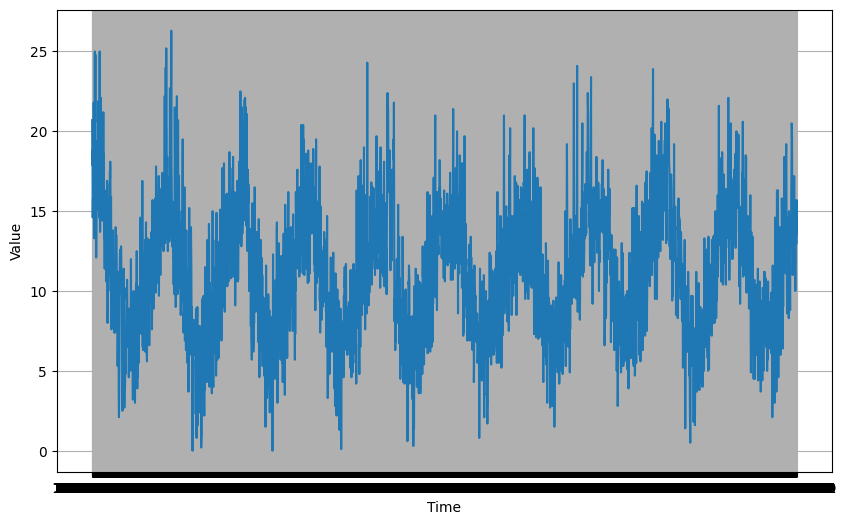

In [7]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

**Expected Output:**
<div>
<img src="images/temp-series.png" width="500"/>
</div>

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:

In [8]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [61]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define your layer architecture. Just as in last week's assignment you will do the layer definition and compilation in two separate steps. Begin by completing the `create_uncompiled_model` function below.

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:

- `Lambda` layers are not required.
- Use a combination of `Conv1D` and `LSTM` layers followed by `Dense` layers

In [62]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.LSTM(64, return_sequences=True),
          tf.keras.layers.LSTM(64),
          tf.keras.layers.Dense(30, activation="relu"),
          tf.keras.layers.Dense(10, activation="relu"),
          tf.keras.layers.Dense(1),
    ]) 
    ### END CODE HERE

    return model

In [63]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Your current architecture is compatible with the windowed dataset! :)


2024-04-23 23:33:24.905694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lecture you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [64]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [65]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 10.2015 - mae: 10.7001 - learning_rate: 1.0000e-04
Epoch 2/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 10.1363 - mae: 10.6352 

2024-04-23 23:34:19.182587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 9.5464 - mae: 10.0445 - learning_rate: 1.1220e-04
Epoch 3/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.3615 - mae: 8.8612

2024-04-23 23:34:21.243180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 8.2097 - mae: 8.7071 - learning_rate: 1.2589e-04
Epoch 4/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.7728 - mae: 6.2633 

2024-04-23 23:34:23.374273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.6565 - mae: 5.1398 - learning_rate: 1.4125e-04
Epoch 5/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.6579 - mae: 3.1227

2024-04-23 23:34:25.500456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.5759 - mae: 3.0392 - learning_rate: 1.5849e-04
Epoch 6/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.0531 - mae: 2.5244

2024-04-23 23:34:27.640901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.0713 - mae: 2.5294 - learning_rate: 1.7783e-04
Epoch 7/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.5374 - mae: 1.9881

2024-04-23 23:34:29.688641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.9276 - mae: 2.3820 - learning_rate: 1.9953e-04
Epoch 8/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6162 - mae: 2.0627 

2024-04-23 23:34:31.756402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.8089 - mae: 2.2585 - learning_rate: 2.2387e-04
Epoch 9/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.0757 - mae: 2.5038

2024-04-23 23:34:33.871218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.9267 - mae: 2.3766 - learning_rate: 2.5119e-04
Epoch 10/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.2644 - mae: 2.7284

2024-04-23 23:34:35.976757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8723 - mae: 2.3240 - learning_rate: 2.8184e-04
Epoch 11/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.9342 - mae: 2.3868

2024-04-23 23:34:38.089117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.7907 - mae: 2.2384 - learning_rate: 3.1623e-04
Epoch 12/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.8974 - mae: 2.3446

2024-04-23 23:34:40.120134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.7897 - mae: 2.2395 - learning_rate: 3.5481e-04
Epoch 13/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.8341 - mae: 2.2877

2024-04-23 23:34:42.201243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.8088 - mae: 2.2584 - learning_rate: 3.9811e-04
Epoch 14/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.9511 - mae: 2.4146

2024-04-23 23:34:44.239381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.7882 - mae: 2.2424 - learning_rate: 4.4668e-04
Epoch 15/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.7951 - mae: 2.2669 

2024-04-23 23:34:46.289393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.6993 - mae: 2.1507 - learning_rate: 5.0119e-04
Epoch 16/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.7692 - mae: 2.2278

2024-04-23 23:34:48.388613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.7337 - mae: 2.1855 - learning_rate: 5.6234e-04
Epoch 17/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.9723 - mae: 2.4199

2024-04-23 23:34:50.431038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8310 - mae: 2.2838 - learning_rate: 6.3096e-04
Epoch 18/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8064 - mae: 2.2615

2024-04-23 23:34:52.549908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.7369 - mae: 2.1821 - learning_rate: 7.0795e-04
Epoch 19/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.4858 - mae: 1.9380

2024-04-23 23:34:54.652395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.6896 - mae: 2.1405 - learning_rate: 7.9433e-04
Epoch 20/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.7837 - mae: 2.2162

2024-04-23 23:34:56.706555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6524 - mae: 2.0971 - learning_rate: 8.9125e-04
Epoch 21/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.4804 - mae: 2.9390

2024-04-23 23:34:58.858392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8494 - mae: 2.3039 - learning_rate: 0.0010
Epoch 22/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.0101 - mae: 2.4960

2024-04-23 23:35:01.034891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.8006 - mae: 2.2518 - learning_rate: 0.0011
Epoch 23/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.5702 - mae: 2.0106

2024-04-23 23:35:03.113349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.5921 - mae: 2.0371 - learning_rate: 0.0013
Epoch 24/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.7363 - mae: 2.1873

2024-04-23 23:35:05.186407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.6908 - mae: 2.1370 - learning_rate: 0.0014
Epoch 25/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.9945 - mae: 2.4447

2024-04-23 23:35:07.284757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6553 - mae: 2.1011 - learning_rate: 0.0016
Epoch 26/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.4953 - mae: 1.9394 

2024-04-23 23:35:09.385125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6165 - mae: 2.0631 - learning_rate: 0.0018
Epoch 27/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.6928 - mae: 2.1360 

2024-04-23 23:35:11.547845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.6377 - mae: 2.0880 - learning_rate: 0.0020
Epoch 28/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.1104 - mae: 2.5754

2024-04-23 23:35:13.661950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.7059 - mae: 2.1535 - learning_rate: 0.0022
Epoch 29/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.6188 - mae: 3.0932

2024-04-23 23:35:15.728680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.9512 - mae: 2.4034 - learning_rate: 0.0025
Epoch 30/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.7387 - mae: 2.1709

2024-04-23 23:35:17.779159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.6523 - mae: 2.0950 - learning_rate: 0.0028
Epoch 31/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.4571 - mae: 1.9102

2024-04-23 23:35:19.868020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.5794 - mae: 2.0299 - learning_rate: 0.0032
Epoch 32/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.0798 - mae: 2.5596 

2024-04-23 23:35:21.945041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.7274 - mae: 2.1794 - learning_rate: 0.0035
Epoch 33/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.0583 - mae: 2.4932 

2024-04-23 23:35:24.037157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.7387 - mae: 2.1840 - learning_rate: 0.0040
Epoch 34/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.7602 - mae: 2.2099 

2024-04-23 23:35:26.138674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.6693 - mae: 2.1192 - learning_rate: 0.0045
Epoch 35/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.7172 - mae: 2.1769

2024-04-23 23:35:28.250093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.6751 - mae: 2.1196 - learning_rate: 0.0050
Epoch 36/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.7482 - mae: 2.1744

2024-04-23 23:35:30.349322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6325 - mae: 2.0740 - learning_rate: 0.0056
Epoch 37/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.8470 - mae: 2.2782

2024-04-23 23:35:32.447788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.6715 - mae: 2.1137 - learning_rate: 0.0063
Epoch 38/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.9489 - mae: 2.4124

2024-04-23 23:35:34.683734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.7447 - mae: 2.1980 - learning_rate: 0.0071
Epoch 39/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.6636 - mae: 2.1112 

2024-04-23 23:35:36.986359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.5974 - mae: 2.0435 - learning_rate: 0.0079
Epoch 40/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.0474 - mae: 2.5252 

2024-04-23 23:35:39.346250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7159 - mae: 2.1639 - learning_rate: 0.0089
Epoch 41/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.7506 - mae: 2.1682

2024-04-23 23:35:41.519012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.6485 - mae: 2.0963 - learning_rate: 0.0100
Epoch 42/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.7080 - mae: 2.1713 

2024-04-23 23:35:43.812457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.8027 - mae: 2.2524 - learning_rate: 0.0112
Epoch 43/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.5203 - mae: 1.9665

2024-04-23 23:35:46.411443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6933 - mae: 2.1416 - learning_rate: 0.0126
Epoch 44/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.8261 - mae: 2.2736

2024-04-23 23:35:48.575137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.8126 - mae: 2.2625 - learning_rate: 0.0141
Epoch 45/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.8704 - mae: 2.3348 

2024-04-23 23:35:50.667972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.9253 - mae: 2.3771 - learning_rate: 0.0158
Epoch 46/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.6180 - mae: 2.0542

2024-04-23 23:35:52.770307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.6540 - mae: 2.1005 - learning_rate: 0.0178
Epoch 47/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.4946 - mae: 1.9269

2024-04-23 23:35:54.862370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.7939 - mae: 2.2421 - learning_rate: 0.0200
Epoch 48/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.9957 - mae: 2.4599

2024-04-23 23:35:56.942064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.7662 - mae: 2.2161 - learning_rate: 0.0224
Epoch 49/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.7465 - mae: 2.2106 

2024-04-23 23:35:59.039331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8536 - mae: 2.3064 - learning_rate: 0.0251
Epoch 50/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.7149 - mae: 2.1643

2024-04-23 23:36:01.164923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8056 - mae: 2.2505 - learning_rate: 0.0282
Epoch 51/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.5123 - mae: 3.9678

2024-04-23 23:36:03.316721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8430 - mae: 3.3069 - learning_rate: 0.0316
Epoch 52/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.0916 - mae: 2.5402

2024-04-23 23:36:05.457708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.0357 - mae: 2.4928 - learning_rate: 0.0355
Epoch 53/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.1217 - mae: 2.5689

2024-04-23 23:36:07.566868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.9383 - mae: 2.3908 - learning_rate: 0.0398
Epoch 54/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.1734 - mae: 2.6417

2024-04-23 23:36:09.650944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.0831 - mae: 2.5376 - learning_rate: 0.0447
Epoch 55/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.2797 - mae: 2.7468

2024-04-23 23:36:11.752313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.0530 - mae: 2.5059 - learning_rate: 0.0501
Epoch 56/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.3296 - mae: 3.8184

2024-04-23 23:36:13.865097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.8738 - mae: 3.3454 - learning_rate: 0.0562
Epoch 57/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.4485 - mae: 2.9035

2024-04-23 23:36:15.956513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.4801 - mae: 2.9377 - learning_rate: 0.0631
Epoch 58/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.0061 - mae: 3.4764 

2024-04-23 23:36:18.094989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.4949 - mae: 2.9603 - learning_rate: 0.0708
Epoch 59/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.2289 - mae: 2.6711

2024-04-23 23:36:20.214817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.2742 - mae: 2.7309 - learning_rate: 0.0794
Epoch 60/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.8044 - mae: 3.2710

2024-04-23 23:36:22.378084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.6688 - mae: 3.1320 - learning_rate: 0.0891
Epoch 61/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.6185 - mae: 3.0945

2024-04-23 23:36:24.527282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.7579 - mae: 3.2254 - learning_rate: 0.1000
Epoch 62/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.9217 - mae: 3.3951

2024-04-23 23:36:26.633319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.8177 - mae: 3.2849 - learning_rate: 0.1122
Epoch 63/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.7128 - mae: 3.1682

2024-04-23 23:36:28.724963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.7652 - mae: 3.2318 - learning_rate: 0.1259
Epoch 64/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.0835 - mae: 3.5541

2024-04-23 23:36:30.821579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8405 - mae: 3.3098 - learning_rate: 0.1413
Epoch 65/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.9086 - mae: 3.3799

2024-04-23 23:36:32.924588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8303 - mae: 3.2967 - learning_rate: 0.1585
Epoch 66/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.7392 - mae: 3.2052

2024-04-23 23:36:35.028845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8576 - mae: 3.3273 - learning_rate: 0.1778
Epoch 67/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.3708 - mae: 2.8407

2024-04-23 23:36:37.131238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.7859 - mae: 3.2555 - learning_rate: 0.1995
Epoch 68/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.4824 - mae: 2.9426

2024-04-23 23:36:39.231197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.7666 - mae: 3.2290 - learning_rate: 0.2239
Epoch 69/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.9696 - mae: 3.4398

2024-04-23 23:36:41.329705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8682 - mae: 3.3351 - learning_rate: 0.2512
Epoch 70/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.8653 - mae: 3.3260

2024-04-23 23:36:43.431421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.7859 - mae: 3.2511 - learning_rate: 0.2818
Epoch 71/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.5263 - mae: 2.9723

2024-04-23 23:36:45.545244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.6873 - mae: 3.1512 - learning_rate: 0.3162
Epoch 72/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.5305 - mae: 2.9934

2024-04-23 23:36:47.641055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.7869 - mae: 3.2533 - learning_rate: 0.3548
Epoch 73/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.0530 - mae: 3.5336

2024-04-23 23:36:49.741266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.9105 - mae: 3.3782 - learning_rate: 0.3981
Epoch 74/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.5530 - mae: 3.0102 

2024-04-23 23:36:51.884184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.7506 - mae: 3.2186 - learning_rate: 0.4467
Epoch 75/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.1692 - mae: 3.6428

2024-04-23 23:36:54.072186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.8498 - mae: 3.3191 - learning_rate: 0.5012
Epoch 76/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.5883 - mae: 3.0525

2024-04-23 23:36:56.298180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.7762 - mae: 3.2429 - learning_rate: 0.5623
Epoch 77/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.2987 - mae: 3.7702 

2024-04-23 23:36:58.504204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.8293 - mae: 3.2998 - learning_rate: 0.6310
Epoch 78/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.2703 - mae: 3.7429

2024-04-23 23:37:00.749113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8924 - mae: 3.3622 - learning_rate: 0.7079
Epoch 79/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.8701 - mae: 3.3374

2024-04-23 23:37:02.904582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8629 - mae: 3.3320 - learning_rate: 0.7943
Epoch 80/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.2650 - mae: 3.7330

2024-04-23 23:37:05.060602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.9550 - mae: 3.4281 - learning_rate: 0.8913
Epoch 81/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.6235 - mae: 3.0997 

2024-04-23 23:37:07.232846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.8854 - mae: 3.3528 - learning_rate: 1.0000
Epoch 82/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.1496 - mae: 3.6195 

2024-04-23 23:37:09.445722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8723 - mae: 3.3430 - learning_rate: 1.1220
Epoch 83/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.1615 - mae: 3.6413 

2024-04-23 23:37:11.612462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.9647 - mae: 3.4357 - learning_rate: 1.2589
Epoch 84/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.4708 - mae: 3.9508 

2024-04-23 23:37:13.776924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.9560 - mae: 3.4280 - learning_rate: 1.4125
Epoch 85/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.2883 - mae: 3.7676 

2024-04-23 23:37:15.970046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.9967 - mae: 3.4679 - learning_rate: 1.5849
Epoch 86/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.0553 - mae: 3.5267 

2024-04-23 23:37:18.211662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.0469 - mae: 3.5165 - learning_rate: 1.7783
Epoch 87/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.1845 - mae: 3.6514 

2024-04-23 23:37:20.411608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.8605 - mae: 3.3283 - learning_rate: 1.9953
Epoch 88/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.3731 - mae: 3.8468 

2024-04-23 23:37:22.606728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.0518 - mae: 3.5224 - learning_rate: 2.2387
Epoch 89/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.2614 - mae: 3.7360

2024-04-23 23:37:24.771780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.0322 - mae: 3.5031 - learning_rate: 2.5119
Epoch 90/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.8729 - mae: 3.3439

2024-04-23 23:37:26.928772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.9420 - mae: 3.4107 - learning_rate: 2.8184
Epoch 91/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.8383 - mae: 4.2964 

2024-04-23 23:37:29.052960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.2699 - mae: 3.7371 - learning_rate: 3.1623
Epoch 92/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.6428 - mae: 3.0910 

2024-04-23 23:37:31.228703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.9106 - mae: 3.3772 - learning_rate: 3.5481
Epoch 93/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8199 - mae: 3.2920

2024-04-23 23:37:33.419920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.1230 - mae: 3.5958 - learning_rate: 3.9811
Epoch 94/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.6303 - mae: 3.1044

2024-04-23 23:37:35.665674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.9211 - mae: 3.3929 - learning_rate: 4.4668
Epoch 95/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.1991 - mae: 4.6842

2024-04-23 23:37:37.871223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.3283 - mae: 3.8034 - learning_rate: 5.0119
Epoch 96/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.6241 - mae: 5.1111

2024-04-23 23:37:39.980870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.5983 - mae: 4.0733 - learning_rate: 5.6234
Epoch 97/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.5619 - mae: 3.0323

2024-04-23 23:37:42.108591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.4699 - mae: 3.9472 - learning_rate: 6.3096
Epoch 98/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.2413 - mae: 3.7163

2024-04-23 23:37:44.203351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.0497 - mae: 3.5200 - learning_rate: 7.0795
Epoch 99/100
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.0080 - mae: 3.4713

2024-04-23 23:37:46.329220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.3954 - mae: 3.8685 - learning_rate: 7.9433
Epoch 100/100
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.8261 - mae: 4.3074 

2024-04-23 23:37:48.474733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.6755 - mae: 4.1493 - learning_rate: 8.9125


2024-04-23 23:37:50.610812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(0.0001, 10.0, 0.0, 10.0)

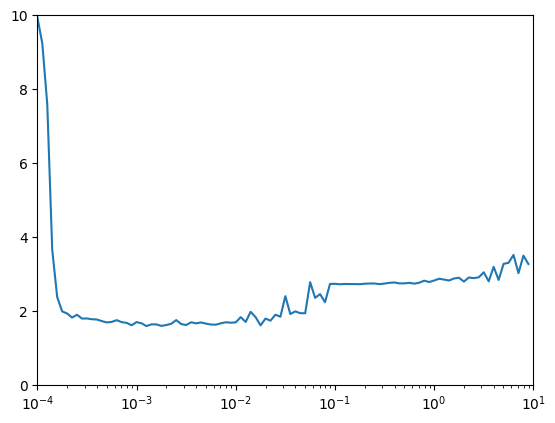

In [67]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

## Compiling the model
Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hints:

- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: loss: nan - mae: nan it is very likely that your network is suffering from exploding gradients. This is a common problem if you used SGD as optimizer and set a learning rate that is too high. If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.

In [68]:
def create_model():

    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                  metrics=["mae"])  
    

    ### END CODE HERE

    return model

In [69]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 9.7280 - mae: 10.2268
Epoch 2/50
 4/77 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.1237 - mae: 8.6229

2024-04-23 23:38:18.872329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.6087 - mae: 8.1045
Epoch 3/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.9866 - mae: 5.4701

2024-04-23 23:38:20.942950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.9906 - mae: 4.4666
Epoch 4/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.9894 - mae: 3.4708

2024-04-23 23:38:23.043126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.5954 - mae: 3.0623
Epoch 5/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.5362 - mae: 2.9993 

2024-04-23 23:38:25.206348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.2587 - mae: 2.7199
Epoch 6/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.2035 - mae: 2.6647

2024-04-23 23:38:27.393187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.9951 - mae: 2.4477
Epoch 7/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.2105 - mae: 2.6478

2024-04-23 23:38:29.528168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.9016 - mae: 2.3489
Epoch 8/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.5984 - mae: 2.0409

2024-04-23 23:38:31.655924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.9040 - mae: 2.3556
Epoch 9/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.9171 - mae: 2.3776

2024-04-23 23:38:33.800019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8108 - mae: 2.2626
Epoch 10/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.0985 - mae: 2.5547

2024-04-23 23:38:35.901068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8690 - mae: 2.3195
Epoch 11/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.0484 - mae: 2.4997

2024-04-23 23:38:38.042182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8218 - mae: 2.2727
Epoch 12/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.1972 - mae: 2.6503 

2024-04-23 23:38:40.184928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8258 - mae: 2.2776
Epoch 13/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.1281 - mae: 2.5969

2024-04-23 23:38:42.319792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8410 - mae: 2.2942
Epoch 14/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.7425 - mae: 2.2108 

2024-04-23 23:38:44.424192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7643 - mae: 2.2184
Epoch 15/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.0185 - mae: 2.4834

2024-04-23 23:38:46.568498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.7946 - mae: 2.2475
Epoch 16/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.7809 - mae: 2.2437

2024-04-23 23:38:48.671403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7350 - mae: 2.1897
Epoch 17/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.7729 - mae: 2.2240

2024-04-23 23:38:50.775835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7475 - mae: 2.2001
Epoch 18/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.8767 - mae: 2.3161 

2024-04-23 23:38:52.912199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7546 - mae: 2.2053
Epoch 19/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.1191 - mae: 2.5853

2024-04-23 23:38:55.043164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7564 - mae: 2.2100
Epoch 20/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.8012 - mae: 2.2309

2024-04-23 23:38:57.167059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7251 - mae: 2.1721
Epoch 21/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.8584 - mae: 2.3189

2024-04-23 23:38:59.303773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7446 - mae: 2.1964
Epoch 22/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.7564 - mae: 2.1983 

2024-04-23 23:39:01.437081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7090 - mae: 2.1543
Epoch 23/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.8659 - mae: 2.3140 

2024-04-23 23:39:03.562030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7366 - mae: 2.1863
Epoch 24/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7898 - mae: 2.2520 

2024-04-23 23:39:05.706122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7210 - mae: 2.1758
Epoch 25/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.8011 - mae: 2.2454

2024-04-23 23:39:07.843793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7558 - mae: 2.2016
Epoch 26/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.9082 - mae: 2.3736

2024-04-23 23:39:09.962892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7656 - mae: 2.2195
Epoch 27/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.5306 - mae: 1.9873

2024-04-23 23:39:12.092660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7264 - mae: 2.1837
Epoch 28/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.8900 - mae: 2.3521 

2024-04-23 23:39:14.223884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7028 - mae: 2.1542
Epoch 29/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.6838 - mae: 2.1323

2024-04-23 23:39:16.362428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6682 - mae: 2.1174
Epoch 30/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.4981 - mae: 1.9418 

2024-04-23 23:39:18.484075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6979 - mae: 2.1485
Epoch 31/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.8351 - mae: 2.2995

2024-04-23 23:39:20.609310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6844 - mae: 2.1367
Epoch 32/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.8567 - mae: 2.3148

2024-04-23 23:39:22.743572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7041 - mae: 2.1566
Epoch 33/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.9283 - mae: 2.3853 

2024-04-23 23:39:24.881697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7125 - mae: 2.1628
Epoch 34/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.9161 - mae: 2.3831 

2024-04-23 23:39:27.032135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6903 - mae: 2.1424
Epoch 35/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6886 - mae: 2.1451 

2024-04-23 23:39:29.216406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6666 - mae: 2.1152
Epoch 36/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.7129 - mae: 2.1577

2024-04-23 23:39:31.395916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6515 - mae: 2.0990
Epoch 37/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.8344 - mae: 2.2934

2024-04-23 23:39:33.502828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6680 - mae: 2.1215
Epoch 38/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.1093 - mae: 2.5888 

2024-04-23 23:39:35.638609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6851 - mae: 2.1398
Epoch 39/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.6652 - mae: 2.1055 

2024-04-23 23:39:37.769745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6557 - mae: 2.1053
Epoch 40/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.4477 - mae: 1.8793

2024-04-23 23:39:39.896385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6000 - mae: 2.0469
Epoch 41/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.4719 - mae: 1.9078

2024-04-23 23:39:42.007397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.5635 - mae: 2.0113
Epoch 42/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7670 - mae: 2.2139

2024-04-23 23:39:44.110528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.6803 - mae: 2.1293
Epoch 43/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.5697 - mae: 1.9955

2024-04-23 23:39:46.214993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6302 - mae: 2.0740
Epoch 44/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.4803 - mae: 1.9443

2024-04-23 23:39:48.383918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6324 - mae: 2.0829
Epoch 45/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.4892 - mae: 1.9289 

2024-04-23 23:39:50.530175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.5817 - mae: 2.0307
Epoch 46/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.5993 - mae: 2.0537

2024-04-23 23:39:52.700236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.5757 - mae: 2.0219
Epoch 47/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.8008 - mae: 2.2548

2024-04-23 23:39:54.818196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6137 - mae: 2.0604
Epoch 48/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.4932 - mae: 1.9360

2024-04-23 23:39:56.939545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.5650 - mae: 2.0110
Epoch 49/50
 3/77 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.6696 - mae: 2.1317

2024-04-23 23:39:59.031868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.5944 - mae: 2.0412
Epoch 50/50
 5/77 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.6750 - mae: 2.1310

2024-04-23 23:40:01.134194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.5827 - mae: 2.0298


2024-04-23 23:40:03.268256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [70]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

In the previous week you saw a faster approach compared to using a for loop to compute the forecasts for every point in the sequence. Remember that this faster approach uses batches of data. 

The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [71]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Now compute the actual forecast:

**Note:** Don't modify the cell below. 

The grader uses the same slicing to get the forecast so if you change the cell below you risk having issues when submitting your model for grading.

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


2024-04-23 23:40:04.353998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


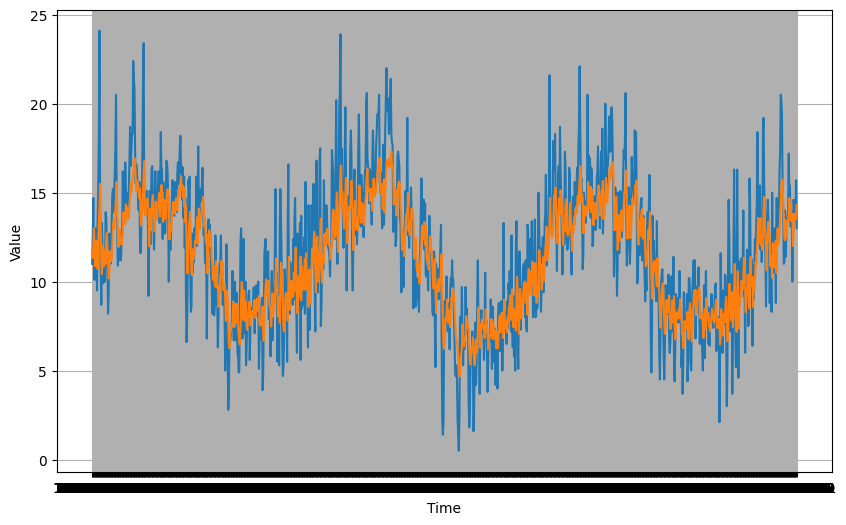

In [72]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [73]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.67, mae: 1.84 for forecast


**To pass this assignment your forecast should achieve a MSE of 6 or less and a MAE of 2 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save the model in the SavedModel format which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy SavedModel directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**

In [75]:
# Save your model in the SavedModel format
model.save('saved_model/my_model.h5')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

a saved_model
a saved_model/my_model.h5


**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging a combination of Tensorflow's layers such as Convolutional and LSTMs! This resulted in a forecast that surpasses all the ones you did previously.

**By finishing this assignment you have finished the specialization! Give yourself a pat on the back!!!**